In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import cv2
import imageio
import numpy as np
from keras.utils import to_categorical
def generator(videos_path,samples, batch_size, categories=64):
  """
    samples serian los nombres de archivos
  """
  w = width
  h = height
  num_samples = len(samples) 
  while True:
    for offset in range(0,num_samples, batch_size):
      batch_samples = samples[offset:offset+batch_size]
      X_train = []
      y_train = []
      for batch_sample in batch_samples:
        vidcap = cv2.VideoCapture(videos_path+batch_sample)      
        #vidcap = imageio.get_reader(videos_path+batch_sample)
        frames = []
        suc, frame = vidcap.read()                
        #for i, frame in enumerate(vidcap):
        while suc: 
          frame = cv2.resize(frame, (w,h), interpolation=cv2.INTER_AREA)
          frame =  cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) if (channels==3) else np.expand_dims(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),2)
          frame = frame.astype(np.float32)
          frame /= 255.0          

          frames.append(frame)
          suc, frame = vidcap.read()        
        
        X_train.append(frames)        
        cat = int(batch_sample.split('_')[0])#  Los mp4 estan categorizados de 1 a 64 y los .avi de 0 a 64, asi que no necesito restar 1        
        y_train.append(to_categorical(cat, num_classes=categories))      
      try:
        X_train = np.asarray(X_train, dtype=np.float32)      
      except:
        print("Trying again...")
        try:
          X_train = np.asarray(X_train, dtype=np.float32)
        except:
          print("failed reading")      
      y_train = np.asarray(y_train)      
      yield X_train, y_train

In [ ]:
import cv2
import imageio
import numpy as np
from keras.utils import to_categorical
def generator_cropped(videos_path,samples, batch_size, categories=64):
  """
    samples serian los nombres de archivos
  """
  height_upper_limit = int(1080/4)
  width_upper_limit = int(1920/4)
  height_to_crop = int(height_upper_limit*3)
  width_to_crop = int(width_upper_limit*3)
  w = width
  h = height
  num_samples = len(samples) 
  while True:
    for offset in range(0,num_samples, batch_size):
      batch_samples = samples[offset:offset+batch_size]
      X_train = []
      y_train = []
      for batch_sample in batch_samples:
        fname, w_limit, h_limit = batch_sample.split(" ")
        w_limit, h_limit = int(w_limit), int(h_limit)
        vidcap = cv2.VideoCapture(videos_path+fname)      
        #vidcap = imageio.get_reader(videos_path+batch_sample)
        frames = []
        suc, frame = vidcap.read()                
        #for i, frame in enumerate(vidcap):
        while suc: 
          frame = frame[h_limit:h_limit+height_to_crop,w_limit:w_limit+width_to_crop,:]
          frame = cv2.resize(frame, (w,h), interpolation=cv2.INTER_AREA)
          frame =  cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) if (channels==3) else np.expand_dims(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),2)
          frame = frame.astype(np.float32)
          frame /= 255.0          

          frames.append(frame)
          suc, frame = vidcap.read()                
        X_train.append(frames)        
        cat = int(batch_sample.split('_')[0])#  Los mp4 estan categorizados de 1 a 64 y los .avi de 0 a 64, asi que no necesito restar 1        
        y_train.append(to_categorical(cat, num_classes=categories))      
      try:
        X_train = np.asarray(X_train, dtype=np.float32)      
      except:
        print("Trying again...")
        try:
          X_train = np.asarray(X_train, dtype=np.float32)
        except:
          print("failed reading")      
      y_train = np.asarray(y_train)      
      yield X_train, y_train

In [ ]:
import matplotlib
from matplotlib.cm import ScalarMappable
from time import sleep
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import os
import pickle
from keras import Model


class set_cbar_zero(Normalize):
  """
  set_cbar_zer(midpoint = float)   default: midpoint = 0
  Normalizes and sets the center of any colormap to the desired valua which is set using midpoint 
  """
  def __init__(self, vmin = None, vmax = None, midpoint = 0, clip = False):
    self.midpoint = midpoint
    Normalize.__init__(self, vmin, vmax, clip)

  def __call__(self, value, clip = None):
    x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
    return np.ma.masked_array(np.interp(value, x, y))


model_name = 'rgb0fold'
exp_folder = "/content/gdrive/My Drive/Informática/Tesina/Experimentos/Conv3D/Multisampling32/"+model_name
weights_path = os.path.join(exp_folder, 'Weights')
pickles_path = os.path.join(exp_folder, 'Pickles')
videos_path = "/content/gdrive/My Drive/Informática/Tesina/Videos/Multisampling32/"
dataset_name = "/content/gdrive/My Drive/Informática/Tesina/DatasetsNames/Multisampling32/"
with open(f'{dataset_name}/train_0fold_Multisampling32.txt') as f:
  test = f.read().split('\n')


def changeTestName(test_names):
  for i in range(len(test_names)):
    test_names_cleaned = list(map(lambda sample: "_".join(sample.split('_')[:-1])+".mp4", test_names))
  return list(set(test_names_cleaned))

def changeTestNameSimplesampling(test_names):
  for i in range(len(test_names)):
    test_names_cleaned = list(map(lambda sample: sample.split('.')[0]+".mp4", test_names))
  return list(set(test_names_cleaned))


norm = set_cbar_zero()
test_cleaned = changeTestName(test)
width = 128
height = 128
channels = 3


MobileNet model


In [ ]:
from keras.applications import MobileNet
from keras.layers import TimeDistributed, Input
from keras import Model
inp = Input(shape=(None, 64, 64, 3))
base_model = MobileNet(input_shape=(64, 64, 3),
                              include_top=False,
                              weights='imagenet',
                              input_tensor=None,
                              pooling='avg',)
x = TimeDistributed(base_model.layers[1])(inp)
mid_y = TimeDistributed(base_model.layers[1])(inp)
middleLayers = base_model.layers[2:40]
for l in middleLayers:
  mid_y = TimeDistributed(l)(mid_y)
y = TimeDistributed(base_model.layers[40])(mid_y)
mid_z = TimeDistributed(base_model.layers[40])(mid_y)
finalLayers = base_model.layers[41:-4]
for l in finalLayers:
  mid_z = TimeDistributed(l)(mid_z)
z = TimeDistributed(base_model.layers[-4])(mid_z)
activation_model = Model(inputs=inp, outputs=[x,y,z])

ConvLSTM and Conv3D

In [ ]:
from keras import Model
if os.path.join(f"{model_name}.pickle") in os.listdir(exp_folder):  
  with open(os.path.join(exp_folder, f"{model_name}.pickle"), 'rb') as pklfile:
    conf = pickle.load(pklfile)    
    model = Model.from_config(conf)
weights = os.listdir(weights_path)
current_epoch = 39 #manual selection
if '{}_epoch_{}.h5'.format(model_name, current_epoch) in os.listdir(weights_path):
  model.load_weights(os.path.join(weights_path,'{}_epoch_{}.h5'.format(model_name, current_epoch)))

convlayers = [model.layers[1].output, model.layers[7].output,model.layers[10].output]
input_layer = model.input
activation_model = Model(inputs=input_layer, outputs=convlayers)
gen = generator(videos_path,['59_5_0_0.avi','16_0_0_0.avi'], 1)

In [ ]:
X, y = next(gen)


In [ ]:
vidcap = cv2.VideoCapture("/content/gdrive/My Drive/Informática/Tesina/Videos/Originals/59_5_1.mp4")
suc, frame = vidcap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

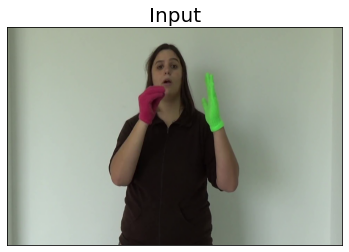

In [ ]:

plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.title('Input', fontsize=20)

fig = plt.imshow(frame, aspect='auto')
plt.savefig('Original60')

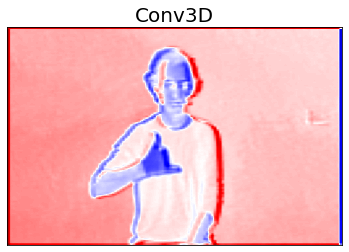

In [ ]:
X, y = next(gen)
convlayers = activation_model.predict(X)
feature_num = 6
feature = convlayers[0][0, 0, :, :, feature_num]
feature = feature / np.abs(feature).max()
fig = plt.imshow(feature, aspect='auto', cmap='seismic', norm=set_cbar_zero(vmax=1, vmin=-1))
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.title('Conv3D', fontsize=20)
#cbar = plt.colorbar()
#cbar.set_label('Activation value')
plt.savefig(f'Conv3DfeatureNoBar{feature_num}_class{y.argmax()}.png')

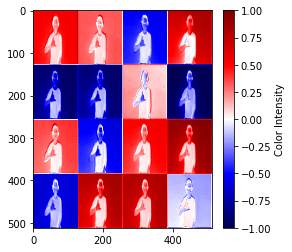

In [ ]:
num_frame=0
n_features = convlayers[0][:, num_frame, :, :, :].shape[-1]
images_per_row=n_features//4
size = convlayers[0][:, num_frame, :, :, :].shape[1]
n_cols = n_features // images_per_row
display_grid = np.zeros((size * n_cols, images_per_row * size))
for col in range(n_cols):
  for row in range(images_per_row):
    channel_image = convlayers[0][:, num_frame, :, :, :][0,:, :, col*images_per_row+row]
    channel_image = channel_image / np.abs(channel_image).max()    
    display_grid[col*size : (col+1) * size, row * size : (row+1) * size] = channel_image
scale = 1./size
plt.figure(figsize=(scale*display_grid.shape[1], scale * display_grid.shape[0]))

plt.grid(False)
fig = plt.imshow(display_grid, aspect='auto', cmap='seismic', norm =set_cbar_zero() )
cbar = plt.colorbar()
cbar.set_label('Color Intensity')

Activations as videos


In [ ]:
def giveMeActivations(activations, y, j, first=False):
  layer_name = 'conv'+str(j)
  for num_frame in range(activations.shape[1]):
    n_features = activations[:, num_frame, :, :, :].shape[-1]
    images_per_row=n_features//4
    size = activations[:, num_frame, :, :, :].shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
      for row in range(images_per_row):
        channel_image = activations[:, num_frame, :, :, :][0,:, :, col*images_per_row+row]
        channel_image = channel_image / np.abs(channel_image).max()
        #channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col*size : (col+1) * size, row * size : (row+1) * size] = channel_image
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1], scale * display_grid.shape[0]))
    
    plt.grid(False)
    if first:
      fig = plt.imshow(display_grid, aspect='auto', cmap='inferno', norm =set_cbar_zero() )
      cbar = plt.colorbar()
      cbar.set_label('Color Intensity')
    else:
      fig = plt.imshow(display_grid, aspect='auto', cmap='inferno')
    plt.yticks([i*activations.shape[2] for i in range(n_cols)])
    plt.xticks([i*activations.shape[2] for i in range(images_per_row+1)])
    
    
    plt.savefig(f'{num_frame}.jpg')
  fourcc = cv2.VideoWriter_fourcc('F', 'M', 'P', '4')
  frame = cv2.imread(f'0.jpg')
  h,w,c = frame.shape
  fps = activations.shape[1]/4
  out = cv2.VideoWriter(f'./{layer_name}_{y.argmax()}_activations.avi', fourcc, fps,(w,h))
  for i in range(activations.shape[1]):
    frame = cv2.imread(f'{i}.jpg')
    out.write(frame)
    os.remove(f'{i}.jpg')
  out.release()

def giveMeOneActivation(activation, y):
  layer_name = 'conv4'
  print("ACTIVACION")
  print(activation.shape)
  n_features = activation[:, :, :, :].shape[-1]
  images_per_row=n_features//4
  size = activation[:, :, :, :].shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = activation[:, :, :, :][0,:, :, col*images_per_row+row]
      channel_image = channel_image / np.abs(channel_image).max()
      #channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col*size : (col+1) * size, row * size : (row+1) * size] = channel_image
  scale = 1./size
  plt.figure(figsize=(scale*display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  
  plt.grid(False)
  if j==0:
    fig = plt.imshow(display_grid, aspect='auto', cmap='inferno', norm =set_cbar_zero() )
    cbar = plt.colorbar()
    cbar.set_label('Color Intensity')
  else:
    fig = plt.imshow(display_grid, aspect='auto', cmap='inferno')
  
  
  plt.savefig(f'ConvLayer4_{y.argmax()}_Activations.jpg')

In [ ]:
X, y = next(gen)
outputlayers = activation_model.predict(X)
giveMeActivations(outputlayers[0], y, 1, True)
giveMeActivations(outputlayers[1], y, 3)
giveMeActivations(outputlayers[2], y,4)

